# How Do Residual Connections Work?

Residual connections were introduced in the paper Deep Residual Learning for Image Recognition (He et al., 2015). Conceptually similar to and mathematically simpler than the gated connections used in highway networks (Srivastava et al., 2015), they made it possible to train much deeper neural networks than was previously possible.

## What are Residual Connections?


A residual connection directly connects non-adjacent layers, bypassing the intermediate ones. This is implemented by simply adding the input of a set of layers to its output.

$$
f(x) = x + g(x)
$$

where $f(x)$ represents the transformation for one or more layers. The authors proposed that it was simpler for a network to learn the residual $g(x)$ rather than the entire transformation $f(x)$, making it easier to train the network.

![residual-connection](residual-connection.jpg)

So, does this work? 

## Let's Set up the Experiment

We will compare two CNN architectures - the ResNet architecture and a comparable network ("DeepCNN") without residual connections.
For each architecture, we will compare networks with 20 and 56 layers.

![fc-resnet](fc-resnet-side-by-side.jpg)







### Let's Define the DeepCNN Model

In [7]:
from typing import Callable

import jax
import jax.numpy as jnp
import optax
import flax.linen as nn

from flax.training import train_state
import tensorflow_datasets as tfds


N = 9 ## Number of basic blocks, each consisting of 2 convolutional layers.

In [8]:

class ConvBlock(nn.Module):

    stride: int
    in_channels: int
    out_channels: int
    kernel_init: Callable = nn.initializers.he_normal()

    @nn.compact
    def __call__(self, x, train):

        x = nn.Conv(features=self.in_channels, kernel_size=(3, 3), strides=1, padding='SAME', use_bias=False, kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.out_channels, kernel_size=(3, 3), strides=self.stride, padding='SAME', use_bias=False, kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        return nn.relu(x)


class DeepCNN(nn.Module):

    kernel_init: Callable = nn.initializers.he_normal()

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding=1, use_bias=False, kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        for _ in range(N-1):
          x = ConvBlock(stride=1, in_channels=16, out_channels=16)(x, train)
        x = ConvBlock(stride=2, in_channels=16, out_channels=32)(x, train)

        for _ in range(N-1):
          x = ConvBlock(stride=1, in_channels=32, out_channels=32)(x, train)
        x = ConvBlock(stride=2, in_channels=32, out_channels=64)(x, train)

        for _ in range(N):
          x = ConvBlock(stride=1, in_channels=64, out_channels=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten

        x = nn.Dense(features=10, kernel_init=self.kernel_init)(x) 


        return x

### Now, Let's Define the ResNet Model

In [9]:
class ResidualBlock(nn.Module):

    in_channels: int
    kernel_init: Callable = nn.initializers.kaiming_normal()

    @nn.compact
    def __call__(self, x, train):
        residual = x

        x = nn.Conv(features=self.in_channels,
                    kernel_size=(3, 3),
                    strides=1,
                    padding="SAME",
                    use_bias=False,
                    kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.in_channels,
                    kernel_size=(3, 3),
                    strides=1,
                    padding="SAME",
                    use_bias=False,
                    kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)

        x = x + residual

        return nn.relu(x)


class DownSampleResidualBlock(nn.Module):

    in_channels: int
    out_channels: int
    kernel_init: Callable = nn.initializers.kaiming_normal()


    @nn.compact
    def __call__(self, x, train):
        residual = x

        x = nn.Conv(features=self.in_channels,
                    kernel_size=(3, 3),
                    strides=1,
                    padding="SAME",
                    use_bias=False,
                    kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.out_channels,
                    kernel_size=(3, 3),
                    strides=(2, 2),
                    padding=(((1, 1), (1, 1))),
                    use_bias=False,
                    kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)

        x = x + self.pad_identity(residual)

        return nn.relu(x)


    @nn.nowrap
    def pad_identity(self, x):
        # Pad identity connection when downsampling
        return jnp.pad(
            x[:, ::2, ::2, ::],
            ((0, 0), (0, 0), (0, 0), (self.out_channels // 4, self.out_channels // 4)),
            "constant",
        )


class ResidualCNN(nn.Module):

    kernel_init: Callable = nn.initializers.kaiming_normal()

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding="SAME", use_bias=False, kernel_init=self.kernel_init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        for _ in range(N-1):
          x = ResidualBlock(in_channels=16)(x, train)
        x = DownSampleResidualBlock(in_channels=16, out_channels=32)(x, train)

        for _ in range(N-1):
          x = ResidualBlock(in_channels=32)(x, train)
        x = DownSampleResidualBlock(in_channels=32, out_channels=64)(x, train)

        for _ in range(N):
          x = ResidualBlock(in_channels=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=10, kernel_init=self.kernel_init)(x) 

        return x

### Next, Let's Set up the CIFAR-10 Dataset 

In [10]:
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils import data


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.array(pic.permute(1, 2, 0), dtype=jnp.float32)

class NumpyLoader(data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=False,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
        )


transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(
        (32, 32),
        padding=4,
        fill=0,
        padding_mode="constant"
    ),

    transforms.RandomHorizontalFlip(),

    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
    ),
    FlattenAndCast(),
])


transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
        ),
        FlattenAndCast(),
    ]
)

train_dataset = CIFAR10(
    root="./CIFAR", train=True, download=True, transform=transforms_train
)

test_dataset = CIFAR10(
    root="./CIFAR", train=False, download=True, transform=transforms_test
)

BATCH_SIZE = 128

train_loader = NumpyLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader= NumpyLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)



Files already downloaded and verified
Files already downloaded and verified


### Finally, Let's Set Up The Training Loop

In [11]:
import pickle

rng = jax.random.PRNGKey(0)

LEARNING_RATE = 0.1
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 180

In [12]:
import flax
from flax.training import checkpoints

def count_parameters(params):
    return sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, params)))


def compute_weight_decay(params):
    param_norm = 0

    weight_decay_params_filter = flax.traverse_util.ModelParamTraversal(
        lambda path, _: ("bias" not in path and "scale" not in path)
    )

    weight_decay_params = weight_decay_params_filter.iterate(params)

    for p in weight_decay_params:
        if p.ndim > 1:
            param_norm += jnp.sum(p ** 2)

    return param_norm

# Create the train state
def create_train_state(rng, cnn, train_size):
    variables = cnn.init(rng, jnp.ones([1, 32, 32, 3]), True)
    params = variables['params']

    num_params = count_parameters(params)
    print(f"Initialized model with {num_params} parameters")

    batch_stats = None
    if "batch_stats" in variables:
        batch_stats = variables['batch_stats']

    steps_per_epoch = train_size//BATCH_SIZE
    scales = [81*steps_per_epoch, 122*steps_per_epoch]
    print(scales)

    lr_schedule = optax.schedules.piecewise_constant_schedule(init_value=LEARNING_RATE,
                                                              boundaries_and_scales={scales[0]: 0.1, scales[1]: 0.1})

    tx = optax.sgd(learning_rate=lr_schedule,
                   momentum=0.9, nesterov=True)


    return train_state.TrainState.create(apply_fn=cnn.apply,
                                         params=params, tx=tx), batch_stats


# Define the training and evaluation steps
@jax.jit
def train_step(state, images, labels, batch_stats):

    def loss_fn(params, batch_stats):
        logits, outputs = state.apply_fn({'params': params, 'batch_stats': batch_stats}, images, train=True, mutable=["batch_stats"])

        updated_batch_stats = outputs['batch_stats']

        one_hot = jax.nn.one_hot(labels, num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot)) + 0.5 * WEIGHT_DECAY * compute_weight_decay(params)
        return loss, (updated_batch_stats, logits)


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    outputs, grads = grad_fn(state.params, batch_stats)
    loss, aux  = outputs
    updated_batch_stats, logits = aux
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    grads_flat = jax.tree_util.tree_flatten(grads)[0][2]
    grad_norm = jnp.linalg.norm(grads_flat)
    state = state.apply_gradients(grads=grads)
    return state, loss, accuracy, updated_batch_stats, grad_norm


@jax.jit
def eval_step(state, images, labels, batch_stats):
    logits = state.apply_fn({'params': state.params, 'batch_stats': batch_stats}, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot)) + 0.5 * WEIGHT_DECAY * compute_weight_decay(state.params)
    return loss, accuracy


# Training loop
def train_and_evaluate(state, batch_stats, metrics):

    iter = 0

    # Prepare data batches
    for epoch in range(NUM_EPOCHS):

        # Training
        train_losses = []
        train_accuracies = []

        for images, labels in train_loader:

            state, loss, accuracy, batch_stats, grad_norm = train_step(state, images, labels, batch_stats)
            train_losses.append(loss)
            train_accuracies.append(accuracy)

            metrics["train_losses"].append(loss)
            metrics["grad_norms"].append(grad_norm)
            iter += 1

        # Evaluation
        test_losses = []
        test_accuracies = []
        for images, labels in test_loader:

            loss, accuracy = eval_step(state, images, labels, batch_stats)
            test_losses.append(loss)
            test_accuracies.append(accuracy)

            metrics["test_losses"].append(loss)


        # Compute mean loss
        epoch_train_loss = jnp.mean(jnp.array(train_losses))
        epoch_test_loss = jnp.mean(jnp.array(test_losses))


        # Compute mean accuracy
        train_accuracy = jnp.mean(jnp.array(train_accuracies)) 
        test_accuracy = jnp.mean(jnp.array(test_accuracies)) 


        print(f"Iter: {iter + 1}, Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return state, batch_stats

In [13]:
OUTPUT_DIR = "/Users/vikram/dev/vikrampawar.com/site/CIFAR10_ResNet"

### Let's train the deep CNN first

In [ ]:
# Create the train state
deepcnn_state, deepcnn_batch_stats = create_train_state(rng, DeepCNN(), 50000)

# Create the metrics object
deepcnn_metrics = {
    "grad_norms": [],
    "train_losses": [],
    "test_losses": []
}

# Run the training
deepcnn_state, deepcnn_batch_stats = train_and_evaluate(deepcnn_state, deepcnn_batch_stats, deepcnn_metrics)

# Save model checkpoint
checkpoints.save_checkpoint(ckpt_dir=f"{OUTPUT_DIR}/ckpts/deepcnn-56",
                            target=deepcnn_state, step=NUM_EPOCHS,
                            overwrite=True)


# Save batch statistics to a file
with open(f"{OUTPUT_DIR}/batch_stats/deepcnn-56.pkl", "wb") as f:
    pickle.dump(deepcnn_batch_stats, f)


# Save metrics to a file
with open(f"{OUTPUT_DIR}/metrics/deepcnn-56.pkl", "wb") as f:
  pickle.dump(deepcnn_metrics, f)

Initialized model with 887674 parameters
[31590, 47580]
Iter: 392, Epoch 1, Train Loss: 50.2543, Test Loss: 50.0755, Train Accuracy: 0.1167, Test Accuracy: 0.1640
Iter: 3911, Epoch 10, Train Loss: 26.2238, Test Loss: 25.1934, Train Accuracy: 0.4198, Test Accuracy: 0.4510
Iter: 7821, Epoch 20, Train Loss: 12.5631, Test Loss: 12.0801, Train Accuracy: 0.5612, Test Accuracy: 0.5836
Iter: 11731, Epoch 30, Train Loss: 6.2287, Test Loss: 6.0489, Train Accuracy: 0.6642, Test Accuracy: 0.6701
Iter: 15641, Epoch 40, Train Loss: 3.3054, Test Loss: 3.2341, Train Accuracy: 0.7286, Test Accuracy: 0.7319
Iter: 19551, Epoch 50, Train Loss: 1.9402, Test Loss: 1.9019, Train Accuracy: 0.7693, Test Accuracy: 0.7702
Iter: 23461, Epoch 60, Train Loss: 1.2954, Test Loss: 1.3155, Train Accuracy: 0.7955, Test Accuracy: 0.7888
Iter: 27371, Epoch 70, Train Loss: 0.9919, Test Loss: 1.0418, Train Accuracy: 0.8175, Test Accuracy: 0.8013
Iter: 31281, Epoch 80, Train Loss: 0.8417, Test Loss: 0.8919, Train Accuracy: 0

### Now let's train the Resnet

In [ ]:
# Create the train state
resnet_state, resnet_batch_stats = create_train_state(rng, ResidualCNN(), 50000)

# Create the metrics object
resnet_metrics = {
    "grad_norms": [],
    "train_losses": [],
    "test_losses": []
}

# Run the training
resnet_state, resnet_batch_stats = train_and_evaluate(resnet_state, resnet_batch_stats, resnet_metrics)


num_params = count_parameters(resnet_state.params)
print(f"Trained model with {num_params} parameters")

# Save model checkpoint
checkpoints.save_checkpoint(ckpt_dir=f"{OUTPUT_DIR}/ckpts/resnet-56",
                            target=resnet_state,
                            step=NUM_EPOCHS,
                            overwrite=True)

# Save batch statistics to a file
with open(f"{OUTPUT_DIR}/batch_stats/resnet-56.pkl", "wb") as f:
    pickle.dump(resnet_batch_stats, f)


# Save metrics to a file
with open(f"{OUTPUT_DIR}/metrics/resnet-56.pkl", "wb") as f:
  pickle.dump(resnet_metrics, f)

Initialized model with 887674 parameters
[31590, 47580]
Iter: 392, Epoch 1, Train Loss: 2.6827, Test Loss: 2.2537, Train Accuracy: 0.1574, Test Accuracy: 0.2668
Iter: 3911, Epoch 10, Train Loss: 0.7960, Test Loss: 0.8215, Train Accuracy: 0.8053, Test Accuracy: 0.8036
Iter: 11731, Epoch 30, Train Loss: 0.4864, Test Loss: 0.6266, Train Accuracy: 0.9047, Test Accuracy: 0.8698
Iter: 19551, Epoch 50, Train Loss: 0.4241, Test Loss: 0.6134, Train Accuracy: 0.9309, Test Accuracy: 0.8865
Iter: 27371, Epoch 70, Train Loss: 0.4042, Test Loss: 0.6415, Train Accuracy: 0.9405, Test Accuracy: 0.8832
Iter: 35191, Epoch 90, Train Loss: 0.2507, Test Loss: 0.5636, Train Accuracy: 0.9917, Test Accuracy: 0.9181
Iter: 43011, Epoch 110, Train Loss: 0.2034, Test Loss: 0.6214, Train Accuracy: 0.9973, Test Accuracy: 0.9196
Iter: 50831, Epoch 130, Train Loss: 0.1813, Test Loss: 0.5837, Train Accuracy: 0.9985, Test Accuracy: 0.9214
Iter: 58651, Epoch 150, Train Loss: 0.1779, Test Loss: 0.6058, Train Accuracy: 0.9

### Results

| Model        | Conv Layers  |50 epochs. | 100 epochs | 180 epochs |
|--------------|--------------|-----------|------------|------------|
| DeepCNN      | 20           |  0.8720   |  0.8808    |  0.8860    |
| ResNet      | 20           |  0.8861   |  0.8881    |  0.8985    |
| DeepCNN      | 56           |  0.7702   |  0.8616    |  0.8602    |  
| ResNet       | 56           |  0.8865   |  0.9174    |  0.9201    |


 The ResNet architecture performs better on the test set in both the 20 and 56 layer configurations. However, notice how much better ResNet-56 does than the corresponding plain network. Clearly, residual connections become much more useful as the depth of the network increases.

In [ ]:
# Load saved checkpoints
deepcnn_state, _ = create_train_state(rng, DeepCNN(), 50000)
deepcnn_state = checkpoints.restore_checkpoint(ckpt_dir=f"{OUTPUT_DIR}/ckpts/deepcnn-56/", target=deepcnn_state, step=NUM_EPOCHS)

resnet_state, _ = create_train_state(rng, ResidualCNN(), 50000)
resnet_state = checkpoints.restore_checkpoint(ckpt_dir=f"{OUTPUT_DIR}/ckpts/resnet-56/", target=resnet_state, step=NUM_EPOCHS)

# Load batch stats
f = open(f"{OUTPUT_DIR}/batch_stats/deepcnn-56.pkl", "rb")
deepcnn_batch_stats = pickle.load(f)

f = open(f"{OUTPUT_DIR}/batch_stats/resnet-56.pkl", "rb")
resnet_batch_stats = pickle.load(f)

# Load metrics
deepcnn_metrics = pickle.load(open(f"{OUTPUT_DIR}/metrics/deepcnn-56.pkl", "rb"))
resnet_metrics = pickle.load(open(f"{OUTPUT_DIR}/metrics/resnet-56.pkl", "rb"))

Initialized model with 887674 parameters
[31590, 47580]


Initialized model with 887674 parameters
[31590, 47580]


## So Why do Skip Connections Work?

### 1.   Better Gradient Propagation




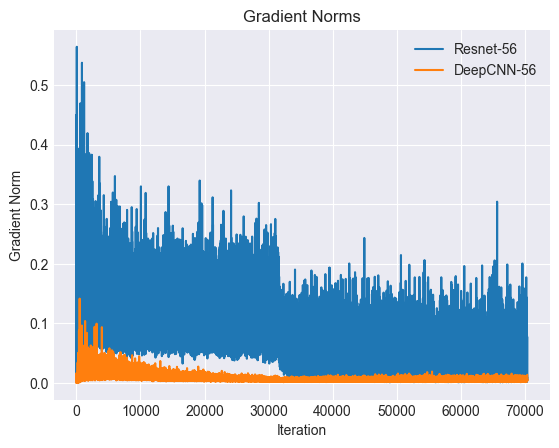

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.plot(resnet_metrics["grad_norms"][30:], label="Resnet-56")
plt.plot(deepcnn_metrics["grad_norms"][20:], label="DeepCNN-56")
plt.title("Gradient Norms")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.legend()

plt.show()

The plot above compares the magnitude of the gradient of the loss function with and without residual connections. It is clear that the gradient is consistently larger with residual connections. 

### 2. Smoother and more convex loss surface


In the paper Visualizing the Loss Landscape of Neural Networks, Li et al. demonstrated that deep neural networks tend to develop progressively more chaotic and non-convex loss surfaces. 

However, by using residual connections, the loss surface tends to remain relatively convex even for very deep networks. 
It is possible to demonstrate this by plotting and comparing the loss surfaces of networks with and without residual connections. 

I will show this in future work. 

### Result: Faster Convergence


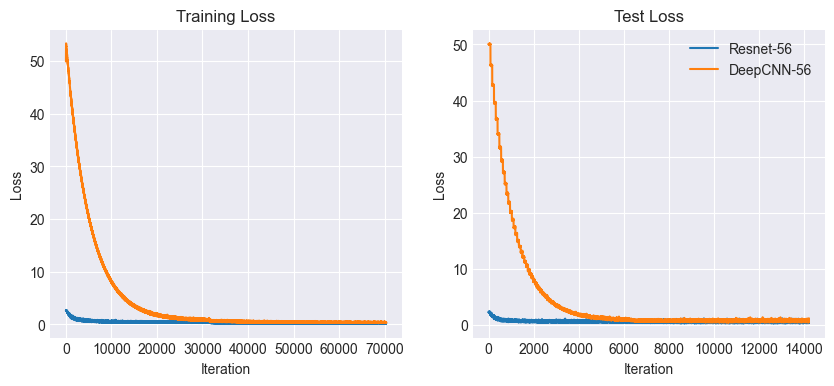

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(resnet_metrics["train_losses"][30:], label="Resnet-56")
axs[0].plot(deepcnn_metrics["train_losses"][30:], label="DeepCNN-56")
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

axs[1].plot(resnet_metrics["test_losses"], label="Resnet-56")
axs[1].plot(deepcnn_metrics["test_losses"], label="DeepCNN-56")
axs[1].set_title("Test Loss")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Loss")

plt.legend()
plt.show()

All this leads to faster convergence. As it is clear from the plots above, the ResNet model converges much quicker than the DeepCNN model.

### References:

1.	Srivastava, R. K., Greff, K., & Schmidhuber, J. (2015). Highway networks. arXiv preprint arXiv:1505.00387.
2.	He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770–778.
3.	Keskar, N. S., Mudigere, D., Nocedal, J., Smelyanskiy, M., & Tang, P. T. P. (2017). On large-batch training for deep learning: Generalization gap and sharp minima. arXiv preprint arXiv:1609.04836.
4.	Im, D. J., Kim, C. D., Jiang, H., & Memisevic, R. (2017). An empirical analysis of the optimization of deep network loss surfaces. arXiv preprint arXiv:1612.04010.
5.	Li, H., Xu, Z., Taylor, G., Studer, C., & Goldstein, T. (2018). Visualizing the loss landscape of neural nets. Advances in Neural Information Processing Systems (NeurIPS), 31.